In [42]:
from collections import defaultdict

def procesar_midi_messages(midi_messages):
    notas = defaultdict(list)
    velocities = defaultdict(list)
    current_notes = {}
    current_time = 0
    current_velocity = 0  # Initialize current_velocity

    for message in midi_messages:
        current_time += message.time
        if message.type == 'note_on':
            current_notes[message.note] = current_time
        elif message.type == 'note_off':
            note = message.note
            start_time = current_notes.pop(note, None)
            if start_time is not None:
                notas[note].append([start_time, current_time])
                velocities[note].append([current_velocity, message.velocity])
        elif message.type == 'control_change' and message.control == 7:
            current_velocity = message.value

    int_tiempos = {note: notas[note] for note in notas}
    int_velocities = {note: velocities[note] for note in velocities}

    return int_tiempos, int_velocities






In [43]:
import numpy as np
import matplotlib.pyplot as plt

def midi_to_freq(midi_note):
    return 440.0 * np.power(2.0, (midi_note - 69) / 12.0)

def temporal(int_tiempos, int_velocities):
    t = np.linspace(0, 4, 5000)
    y = np.zeros_like(t)

    for note, times in int_tiempos.items():
        freq = midi_to_freq(note)
        for time in times:
            start, end = time
            mask = (t >= start) & (t < end)
            y[mask] += np.sin(2 * np.pi * freq * t[mask]) * int_velocities[note][0][1] / 128.0

    return t, y


In [44]:
import numpy as np
from scipy import signal

def calcular_espectrograma(t, y):
    # Calcular la frecuencia de muestreo
    fs = 1 / (t[1] - t[0])

    # Calcular el espectrograma
    f, t, sxx = signal.spectrogram(y, fs)

    return t, f, sxx

{60: [[0, 0.5]], 62: [[0.5, 1.0]], 64: [[1.0, 1.5]], 65: [[1.5, 2.0]], 67: [[2.0, 2.5]], 69: [[2.5, 3.0]], 71: [[3.0, 3.5]], 72: [[3.5, 4.0]]}
{60: [[0, 64]], 62: [[0, 64]], 64: [[0, 64]], 65: [[0, 64]], 67: [[0, 64]], 69: [[0, 64]], 71: [[0, 64]], 72: [[0, 64]]}


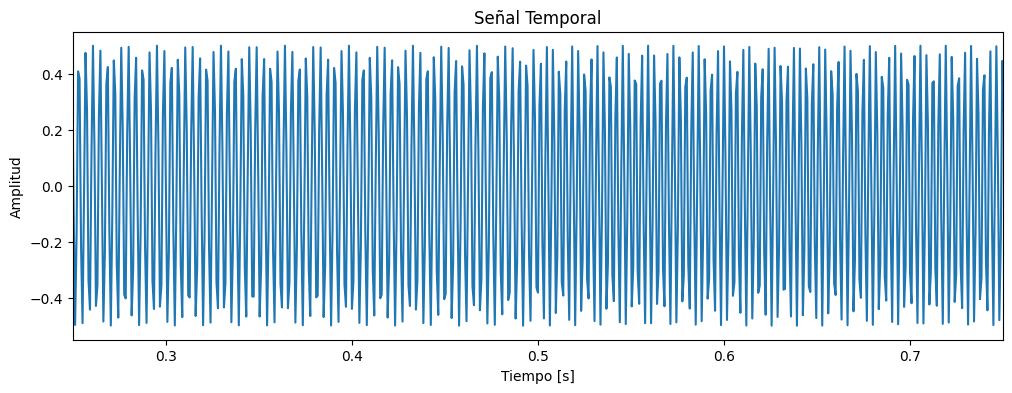

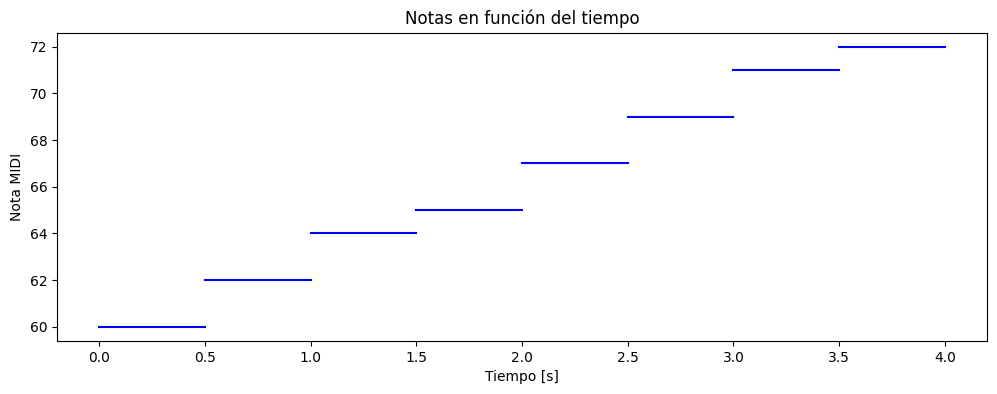

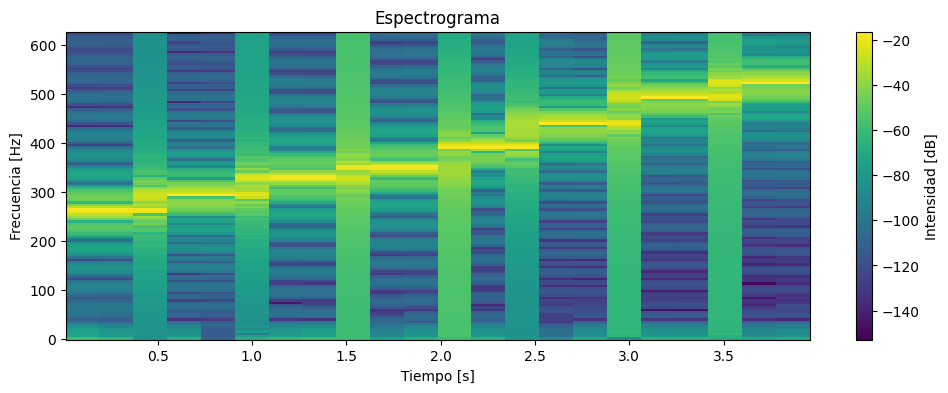

In [46]:
import mido

midi_messages = mido.MidiFile('test_file.mid')

int_tiempos, int_velocities = procesar_midi_messages(midi_messages)
print(int_tiempos)
print(int_velocities)

# Generar la señal temporal
time, y = temporal(int_tiempos, int_velocities)

# Graficar la señal temporal
plt.figure(figsize=(12, 4))
plt.plot(time, y)
plt.title('Señal Temporal')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.xlim([0.25, 0.75])
plt.show()

# Graficar las notas en función del tiempo
plt.figure(figsize=(12, 4))
for note, intervals in int_tiempos.items():
    for interval in intervals:
        plt.plot(interval, [note, note], color='blue')
plt.title('Notas en función del tiempo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Nota MIDI')
plt.show()

#Grfico del espectrograma
t, f, sxx = calcular_espectrograma(time, y)
plt.figure(figsize=(12, 4))
plt.pcolormesh(t, f, 10 * np.log10(sxx))
plt.title('Espectrograma')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.colorbar(label='Intensidad [dB]')
plt.show()
